In [1]:
library('dplyr', warn.conflicts = FALSE)
library('ggplot2')
library('corrplot', warn.conflicts = FALSE)
library('gridExtra', warn.conflicts = FALSE)
library('ggcorrplot')
library('DataCombine')
library('fastDummies')

options(repr.plot.width = 15, repr.plot.height = 7)

corrplot 0.92 loaded



O dado que escolhi é referente a reservas de hotéis portugueses e pode ser encontrado no Kaggle, por meio [desse link](https://www.kaggle.com/datasets/mojtaba142/hotel-booking).

Abaixo temos uma visão geral dos dados.

In [2]:
hotel_data <- read.csv('hotel_booking.csv', stringsAsFactors = FALSE)
head(hotel_data)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,⋯,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone.number,credit_card
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Resort Hotel,0,342,2015,July,27,1,0,0,2,⋯,Transient,0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
2,Resort Hotel,0,737,2015,July,27,1,0,0,2,⋯,Transient,0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
3,Resort Hotel,0,7,2015,July,27,1,0,1,1,⋯,Transient,75,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
4,Resort Hotel,0,13,2015,July,27,1,0,1,1,⋯,Transient,75,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,Transient,98,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
6,Resort Hotel,0,14,2015,July,27,1,0,2,2,⋯,Transient,98,0,1,Check-Out,2015-07-03,Jasmine Fletcher,JFletcher43@xfinity.com,190-271-6743,************9263


Uma pequena explicação para cada dado pode ser vista abaixo

Nome da feature             | Descrição
----------------------------|------------------
ADR                         | Average Daily Rate.
Adults                      | Número de adulto.
Agent                       | ID da agência de viagens que realizou a reserva.
ArrivalDateDayOfMonth       | Dia do mês em que o cliente chega.
ArrivalDateMonth            | Mês de chegada do cliente.
ArrivalDateWeekNumber       | Semana do ano em que o cliente chega.
ArrivalDateYear             | Ano da reserva.
AssignedRoomType            | Código do tipo de quarto reservado pelo cliente.
Babies                      | Número de bebês.
BookingChanges              | Número de alterações na reserva.
Children                    | Número de crianças.
Company                     | ID da companhia que fez a reserva.
Country                     | País de origem do cliente.
CreditCard                  | Número do cartão do cliente.
CustomerType                | Tipo de cliente: Contract, Group, Transient e Transient-party (reserva Transient relacionada a outra reserva Transient).
DaysInWaitingList           | Número de dias que a reserva ficou na lista de espera (estava no sistema mas não tinha sido confirmada ainda pelo cliente).
DepositType                 | Indica se o cliente realizou algum tipo de depósito para efetuar a reserva. No Deposit, Non Refund (pagamento integral) e Refundable (pagamento parcial).
DistributionChannel         | Meio de reserva. TA (Travel Agents) e TO (Tour Operators).
Email                       | Email do cliente.
Hotel                       | Tipo de hotel.
IsCanceled                  | Variável de interesse. 1 para reservas canceladas e 0 para não canceladas.
IsRepeatedGuest             | Variável indicadora para clientes reincidentes.
LeadTime                    | Tempo decorrido entre o primeiro acesso a reserva e a data de check-in.
MarketSegment               | Segmento de mercado. TA (Travel Agents) e TO (Tour Operators).
Meal                        | Tipo de refeição. Undefined/SC (sem pacote), BB (Bed & Breakfast), HB (Half Board) e FB (Full Board).
Name                        | Nome do cliente.
PhoneNumber                 | Telefone do cliente.
PreviousBookingsNotCanceled | Número de reservas que não foram canceladas anteriormente por esse cliente.
PreviousCancellations       | Número de reservas que foram canceladas anteriormente por esse cliente.
RequiredCarParkingSpaces    | Número de vagas de garagem reservadas pelo cliente.
ReservationStatus           | Último status da reserva: Canceled, Check-Out , No-Show.
ReservationStatusDate       | Data do status acima.
ReservedRoomType            | Código do tipo de quarto reservado.
StaysInWeekendNights        | Número de noites de fins de semana que o cliente ficará no hotel.
StaysInWeekNights           | Número de noites em dias de semana que o cliente ficará no hotel.
TotalOfSpecialRequests      | Número de pedidos especiais realizados pelo cliente.

Como esses dados são reais, os campos originais que faziam referência ao hotel e seus clientes foram substituídos no banco, seja por meio de uma nomeação genérica (como Resort Hotel ou City Hotel para tipo de hotel) ou seja pela geração aleatória, como nos casos dos clientes.

Além disso, como os dados dos clientes não é relevante para nós aqui (poderíamos utilizar para ver reincidência de cancelamento da reserva, mas já temos uma coluna com esse dado), vou excluir as colunas que contém tais dados.

In [3]:
remove <- c('name', 'email', 'phone.number', 'credit_card')
hotel_data <- hotel_data[, - which(names(hotel_data) == remove)]

Um outro problema que pode ocorrer é a falta de dados em algumas linhas de certas colunas. Vejamos se isso está ocorrendo aqui e em que escala.

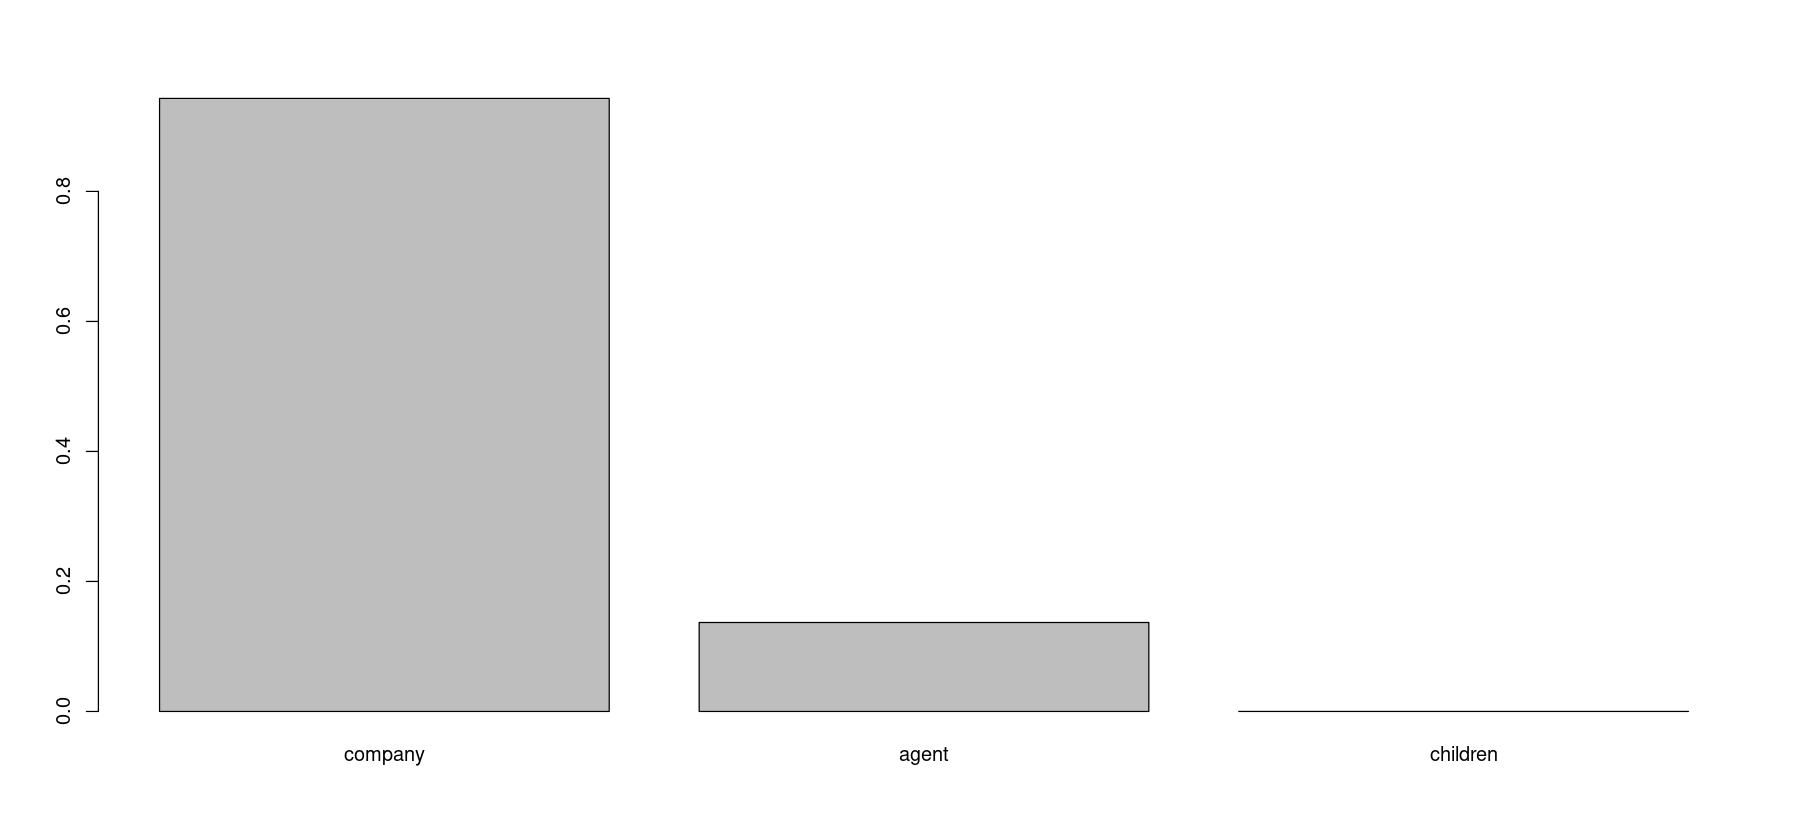

In [4]:
inds <- which(colMeans(is.na(hotel_data)) != 0)
NA_cols <- sort(colMeans(is.na(hotel_data[, inds])), 
                decreasing = TRUE)

barplot(NA_cols)

Conforme o gráfico acima, podemos ver que mais de 80% das linhas não possuem o dado referente a coluna `company`. Como isso representa um alto volume de dados, vou excluir essa coluna do nosso dataset e reavaliar.

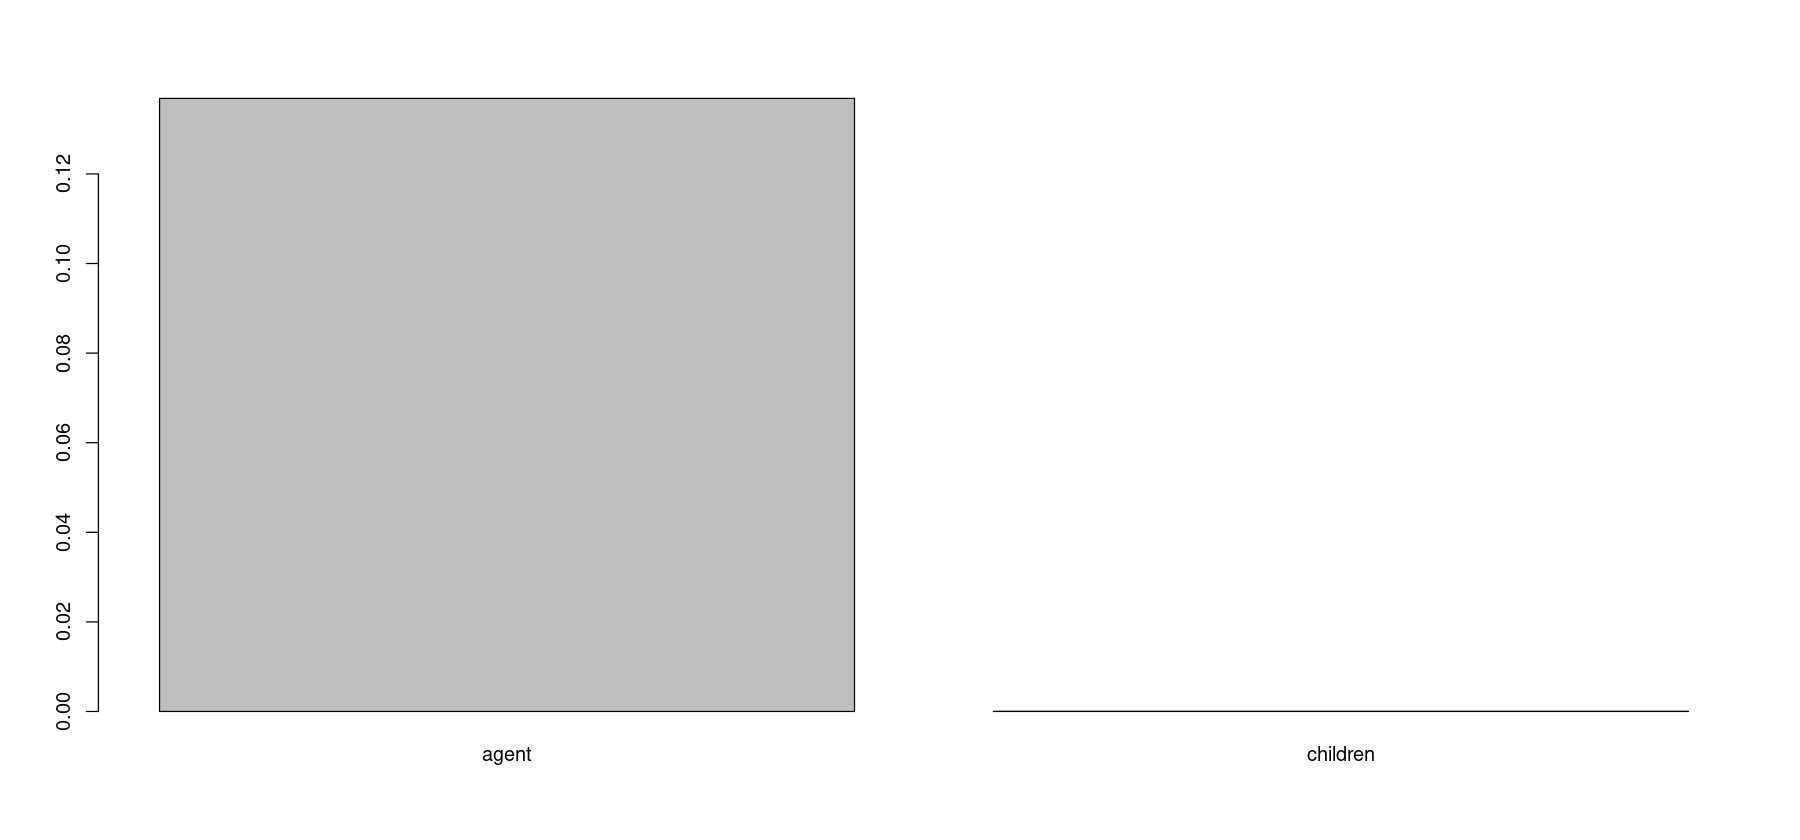

In [5]:
hotel_data <- hotel_data[, - which(names(hotel_data) == 'company')]
inds <- which(colMeans(is.na(hotel_data)) != 0)
NA_cols <- sort(colMeans(is.na(hotel_data[, inds])), 
                decreasing = TRUE)

barplot(NA_cols)

Por termos poucas linhas sem a coluna `children` podemos simplesmente relizar a remoção das linhas cujo campo é NA. Agora, para a coluna `agent`, onde pouco mais de 12% das linhas tem o dado faltando, podemos proceder removendo a coluna toda ou as linhas que não possuem essa entrada. Para evitar remover mais uma coluna, vou optar por remover essas linhas ao invés de remover a coluna.

Por fim, também podemos arrumar o mês de chegada para a sequência numérica, ao invés de textual.

In [6]:
hotel_data <- DropNA(hotel_data, 'children')
hotel_data <- DropNA(hotel_data, 'agent')
rownames(hotel_data) <- 1:nrow(hotel_data)

months <- c('January', 'February', 'March',
            'April', 'May', 'June',
            'July', 'August', 'September',
            'October', 'November', 'December')

for (i in 1:12){
    ind <- hotel_data$arrival_date_month %in% months[i]
    hotel_data[ind, 5] <- i
    }

hotel_data <- transform(hotel_data, arrival_date_month = as.numeric(arrival_date_month))
levels(hotel_data$arrival_date_month) <- c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)

4 rows dropped from the data frame because of missing values.

16338 rows dropped from the data frame because of missing values.



Feito isso, temos nosso dataset pronto e podemos iniciar nossa exploração dos dados. Inicialmente, vamos olhar o sumário dos dados.

In [7]:
summary(hotel_data)

    hotel            is_canceled     lead_time     arrival_date_year
 Length:103048      Min.   :0.00   Min.   :  0.0   Min.   :2015     
 Class :character   1st Qu.:0.00   1st Qu.: 26.0   1st Qu.:2016     
 Mode  :character   Median :0.00   Median : 79.0   Median :2016     
                    Mean   :0.39   Mean   :111.7   Mean   :2016     
                    3rd Qu.:1.00   3rd Qu.:169.0   3rd Qu.:2017     
                    Max.   :1.00   Max.   :629.0   Max.   :2017     
 arrival_date_month arrival_date_week_number arrival_date_day_of_month
 Min.   : 1.000     Min.   : 1.00            Min.   : 1.00            
 1st Qu.: 4.000     1st Qu.:17.00            1st Qu.: 8.00            
 Median : 7.000     Median :28.00            Median :16.00            
 Mean   : 6.594     Mean   :27.34            Mean   :15.78            
 3rd Qu.: 9.000     3rd Qu.:38.00            3rd Qu.:24.00            
 Max.   :12.000     Max.   :53.00            Max.   :31.00            
 stays_in_weekend_ni

Olhando para os dados, algumas coisas chamam a atenção, como o cliente que está levando 10 bebês ou 10 crianças para o hotel. Ou o cliente que esperou mais de um ano na lista de espera, bem como o que reservou com mais de um ano e meio de antecedência.

Saindo do lado mais descontraído dos dados e voltando para o mais análitico, os clientes que tiveram muitas reservas canceladas anteriormente (como quem cancelou 26 vezes) ou que fazem muitas alterações na reserva (um cliente fez 18), chamam a atenção para nossa análise.

Por fim, podemos ver que temos `ADR` negativa, o que não faz sentido. Outra coisa que não faz muito sentido é o total de adultos ser $0$. Nesse caso, vou filtrar apenas os dados com esses valores sendo positivos.

In [8]:
hotel_data = hotel_data[hotel_data$adults > 0, ]
hotel_data = hotel_data[hotel_data$adr > 0, ]

Inicialmente, vimos que o hotel é português. Vamos, então, analisar a coluna `country`, realizando uma contagem de quantos clientes são oriundos de cada país.

In [9]:
sort(table(hotel_data$country))


  AIA   ASM   ATF   BDI   BFA   BHS   BWA   CYM   DJI   DMA   FJI   GUY   HND 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  KIR   LCA   MLI   MMR   MRT   MWI   NAM   NCL   NIC   NPL   PLW   PYF   RWA 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
  SDN   SLE   UMI   VGB   ABW   ATA   COM   GLP   IMN   KHM   KNA   LAO   MYT 
    1     1     1     1     2     2     2     2     2     2     2     2     2 
  SLV   SYC   SYR   TGO   UGA   ZMB   BEN   ETH   GGY   LIE   MKD   MNE   TMP 
    2     2     2     2     2     2     3     3     3     3     3     3     3 
  TZA   UZB   BRB   GAB   GHA   GTM   MCO   PRI   PRY   SUR   ZWE   BHR   CAF 
    3     3     4     4     4     4     4     4     4     4     4     5     5 
  FRO   GNB   LBY   CIV   CUB   JAM   KEN   LKA   AND   JEY   MUS   ARM   VNM 
    5     5     5     6     6     6     6     6     7     7     7     8     8 
  BOL   CMR   PAN   TJK   ALB   BIH   IRQ   SEN   B

Como os dados de cada país caem de forma rápida, vou reformular essa coluna de modo a criar uma variável indicadora para o cliente que é estrangeiro, além de remover as $152$ linhas que não contém essa informação.

In [10]:
hotel_data = hotel_data[hotel_data$country != '', ]
hotel_data = hotel_data %>% mutate(InternationalCustomer = case_when(country == 'PRT' ~ 0,
                                                                     country != 'PRT' ~ 1))
hotel_data = hotel_data[, - which(names(hotel_data) == 'country')]

Por fim, vamos remover os clientes cujo status está assinalado No-Show, mantendo apenas os clientes que cancelaram ou que realizaram check-out.

In [11]:
hotel_data = hotel_data[hotel_data$reservation_status != 'No-Show', ]
table(hotel_data$reservation_status)


 Canceled Check-Out 
    39005     61661 

Feitas tais modificações, podemos olhar, novamente ao sumário dos dados.

In [12]:
write.csv(hotel_data, 'dados_limpos.csv', row.names = FALSE)
summary(hotel_data)

    hotel            is_canceled       lead_time     arrival_date_year
 Length:100666      Min.   :0.0000   Min.   :  0.0   Min.   :2015     
 Class :character   1st Qu.:0.0000   1st Qu.: 27.0   1st Qu.:2016     
 Mode  :character   Median :0.0000   Median : 80.0   Median :2016     
                    Mean   :0.3875   Mean   :112.7   Mean   :2016     
                    3rd Qu.:1.0000   3rd Qu.:170.0   3rd Qu.:2017     
                    Max.   :1.0000   Max.   :629.0   Max.   :2017     
 arrival_date_month arrival_date_week_number arrival_date_day_of_month
 Min.   : 1.000     Min.   : 1.00            Min.   : 1.00            
 1st Qu.: 4.000     1st Qu.:17.00            1st Qu.: 8.00            
 Median : 7.000     Median :28.00            Median :16.00            
 Mean   : 6.599     Mean   :27.35            Mean   :15.77            
 3rd Qu.: 9.000     3rd Qu.:38.00            3rd Qu.:23.00            
 Max.   :12.000     Max.   :53.00            Max.   :31.00            
 stays

Vamos, agora, ver como o número de clientes que cancelaram a reserva se comporta de acordo com algumas outras features. Primeiramente, vamos cruzar com o tipo de hotel.

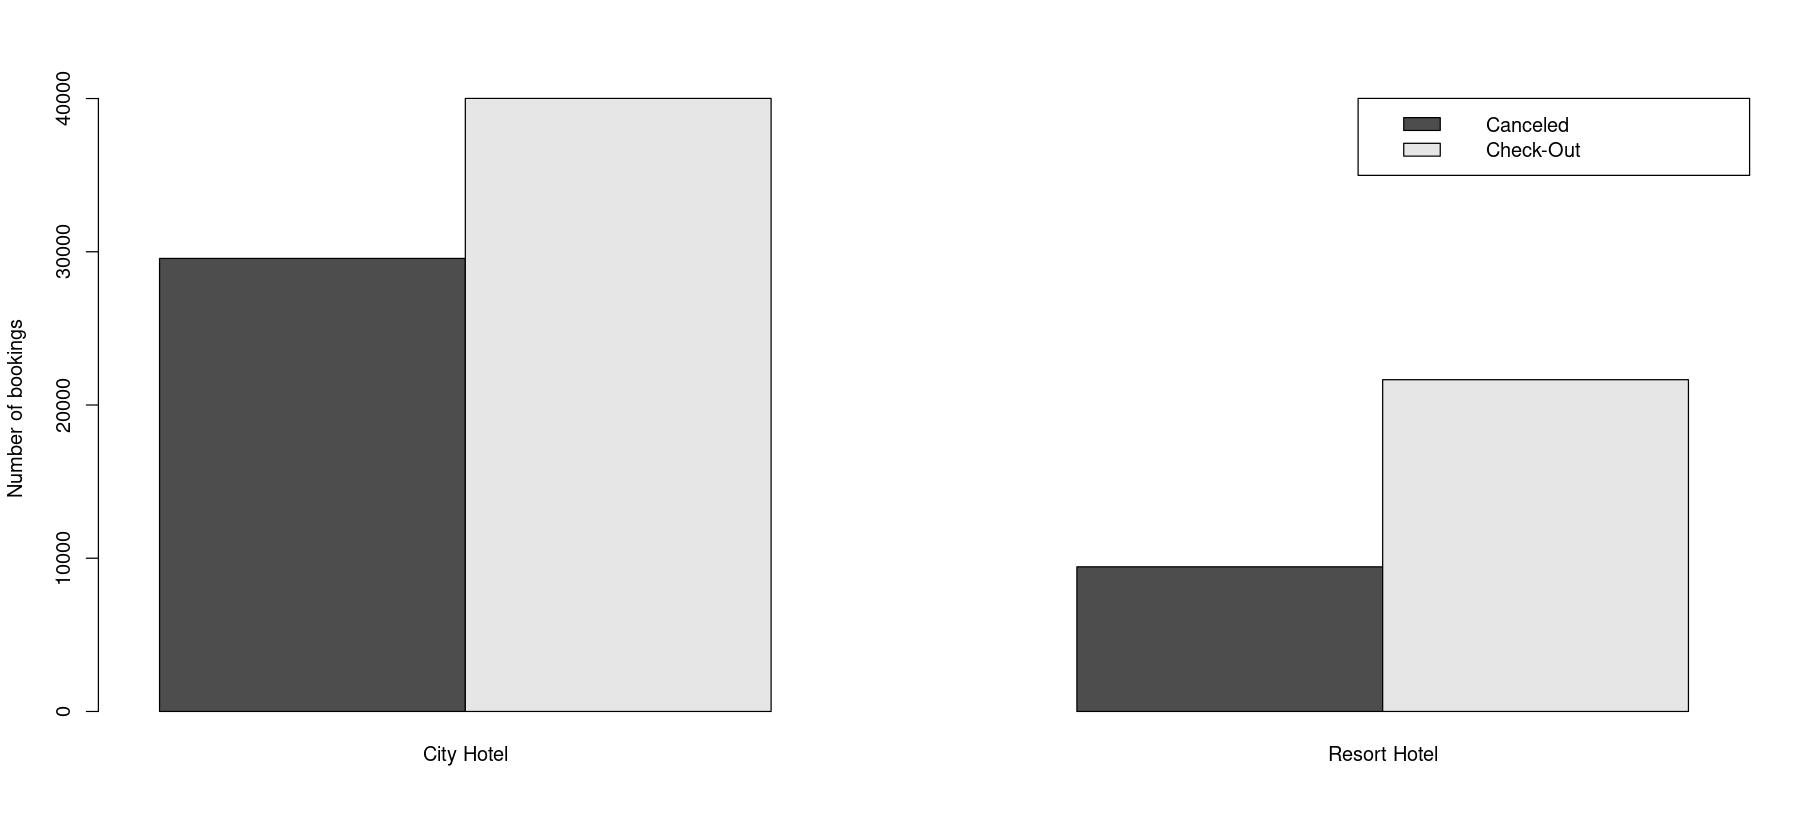

In [13]:
aux <- with(hotel_data, table(reservation_status, hotel))
barplot(aux,
        beside = TRUE,
        ylab = 'Number of bookings',
        legend.text = rownames(aux),
        args.legend = list(x = 'topright'))

Diretamente do gráfico acima podemos ver que nos hotéis da cidade a proporção de cancelamentos de reserva é maior que nos demais. Isso pode nos indicar que existe uma correlação entre o hotel escolhido e o fato do cliente cancelar a reserva.

Agora vamos para a análise de reservas mensais.

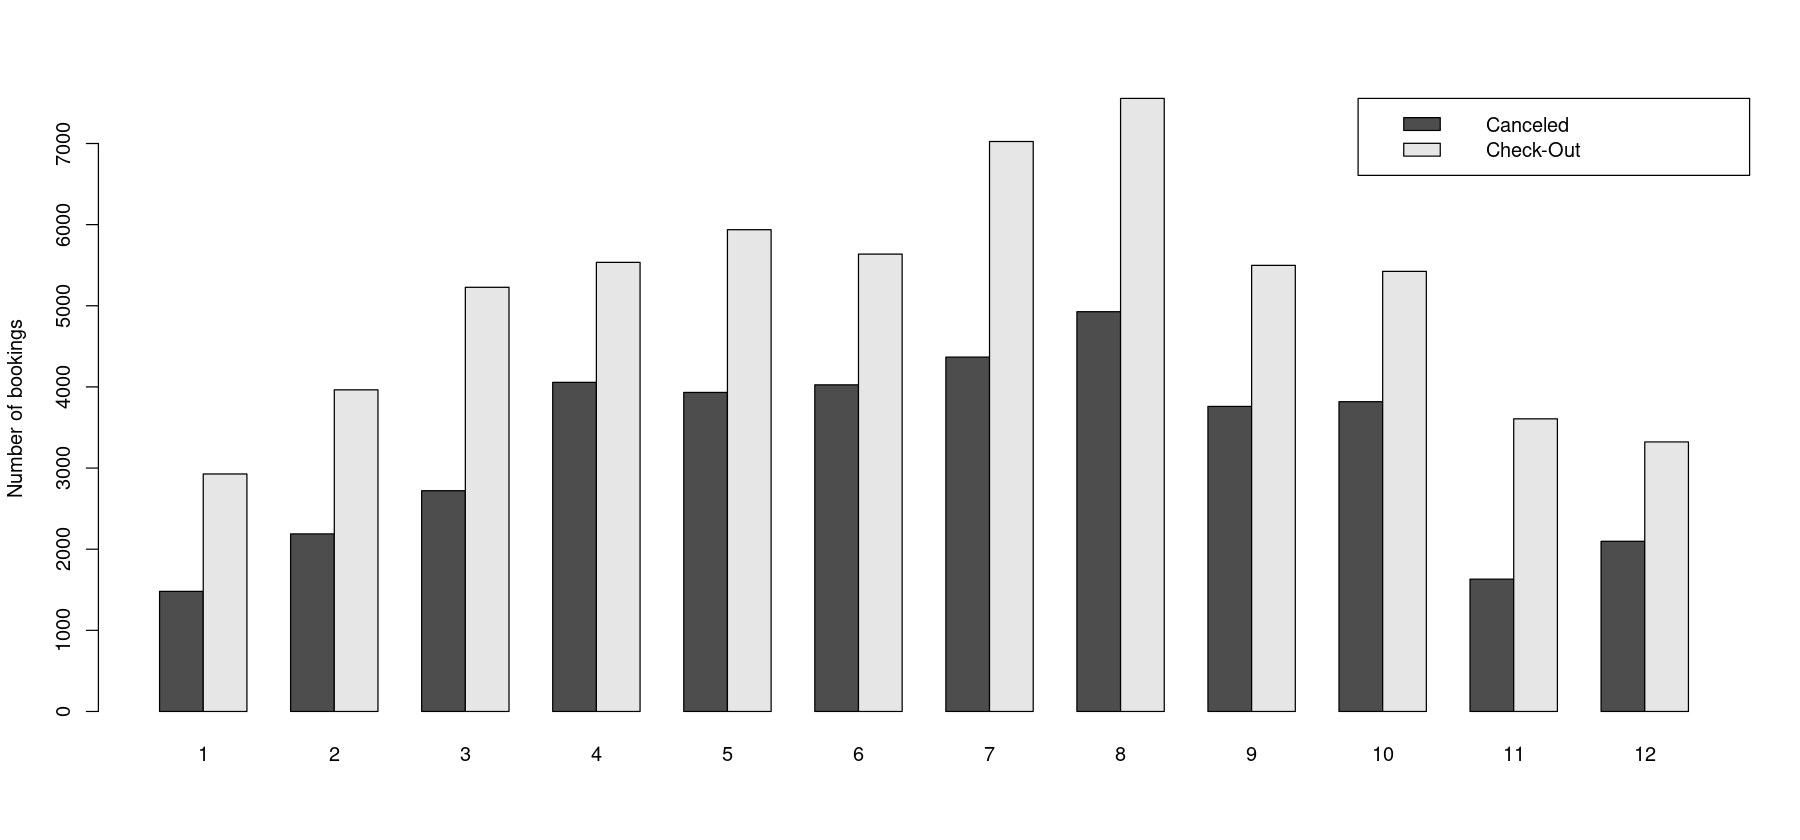

In [14]:
aux <- with(hotel_data, table(reservation_status, arrival_date_month))
barplot(aux,
        beside = TRUE,
        ylab = 'Number of bookings',
        legend.text = rownames(aux),
        args.legend = list(x = 'topright'))

Olhando para o mês de chegada, podemos ver que ocorrem poucas flutuações na proporção de cancelamentos em cada mês. Um detalhe interessante é que, nos meses de janeiro, março e novembro os cancelamentos estão um pouco abaixo do que os demais meses.

Vamos fazer a avaliação por dia de chegada.

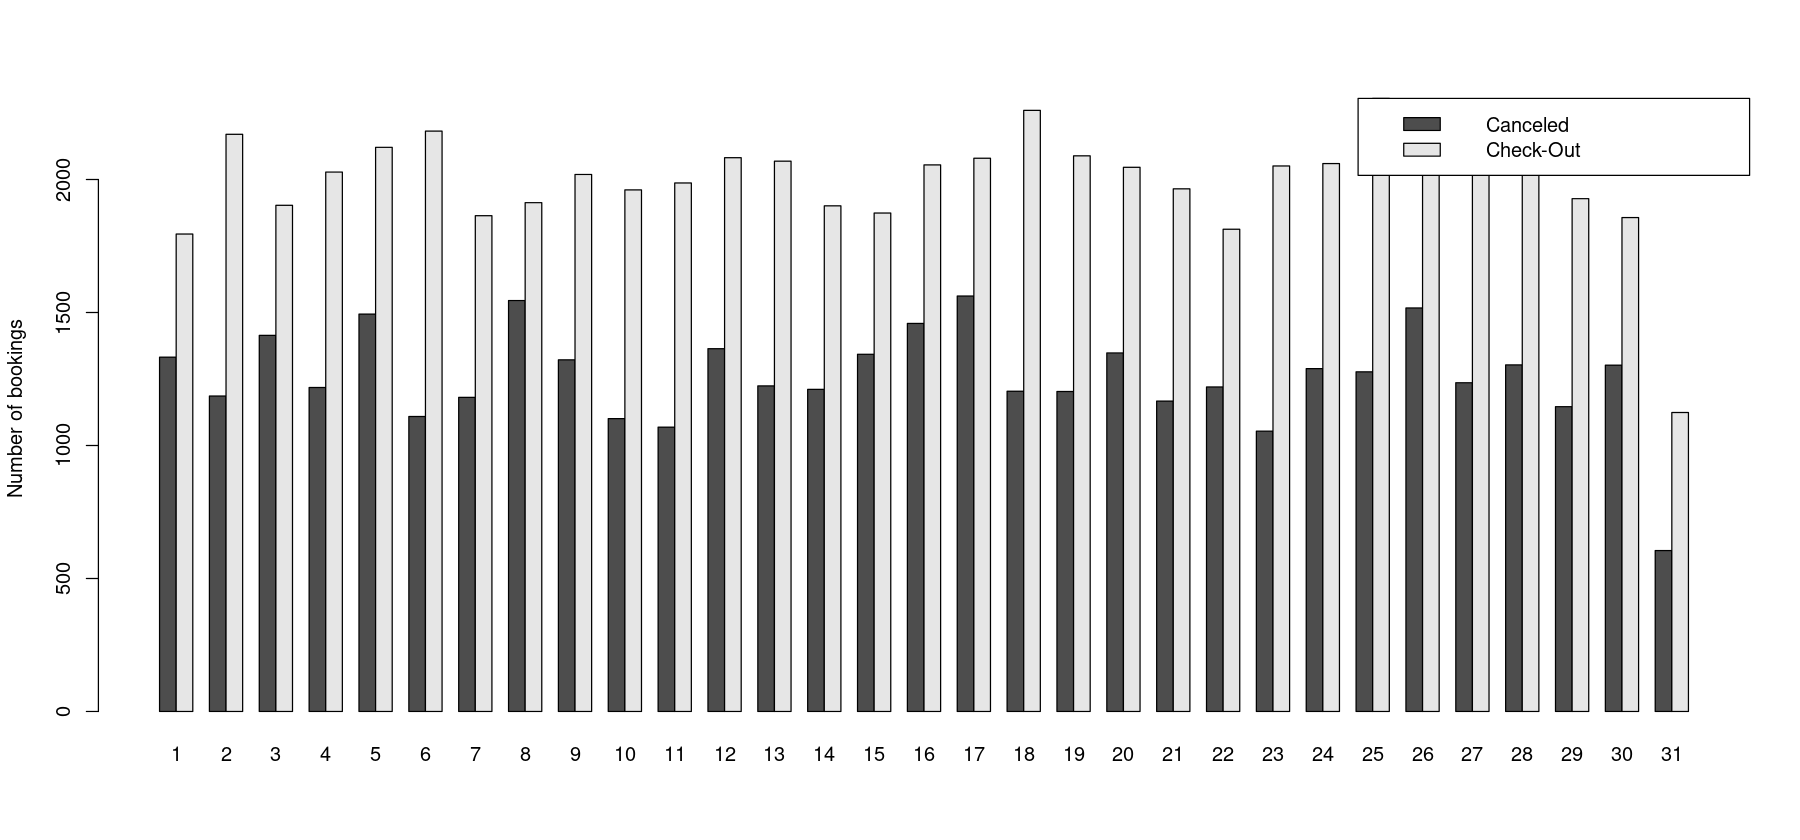

In [15]:
aux <- with(hotel_data, table(reservation_status, arrival_date_day_of_month))
barplot(aux,
        beside = TRUE,
        ylab = 'Number of bookings',
        legend.text = rownames(aux),
        args.legend = list(x = 'topright'))

Novamente, olhando por dia de chegada, os cancelamentos parecem seguir uma mesma proporção, sem nenhum dado que pareça explicar o cancelamento da reserva.

Por outro lado, vendo o tipo de cliente temos

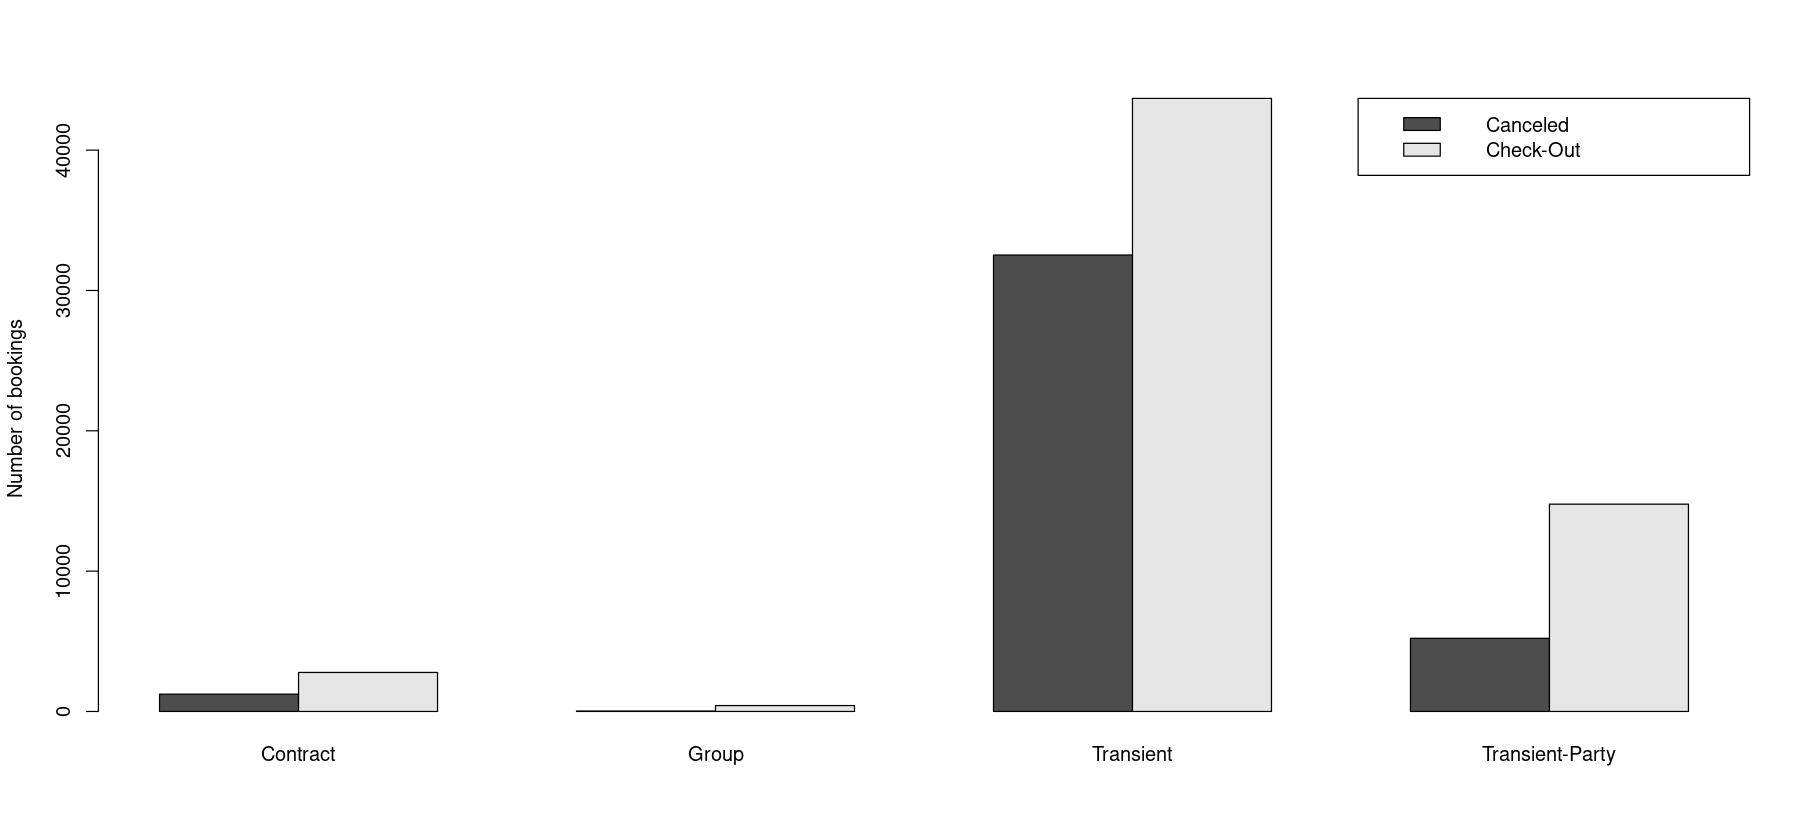

In [16]:
aux <- with(hotel_data, table(reservation_status, customer_type))
barplot(aux,
        beside = TRUE,
        ylab = 'Number of bookings',
        legend.text = rownames(aux),
        args.legend = list(x = 'topright'))

Podemos ver que clientes que vão em grupo tendem a cancelar menos, enquanto os clientes transientes são os que possuem a maior taxa de cancelamento, seguindo pelos clientes que possuem contrato.

Analisando os pagamentos das reservas, temos que os clientes que pagaram integralmente adiantado não cancelaram, mas quem pagou parcialmente cancelou, como sugere o gráfico abaixo.

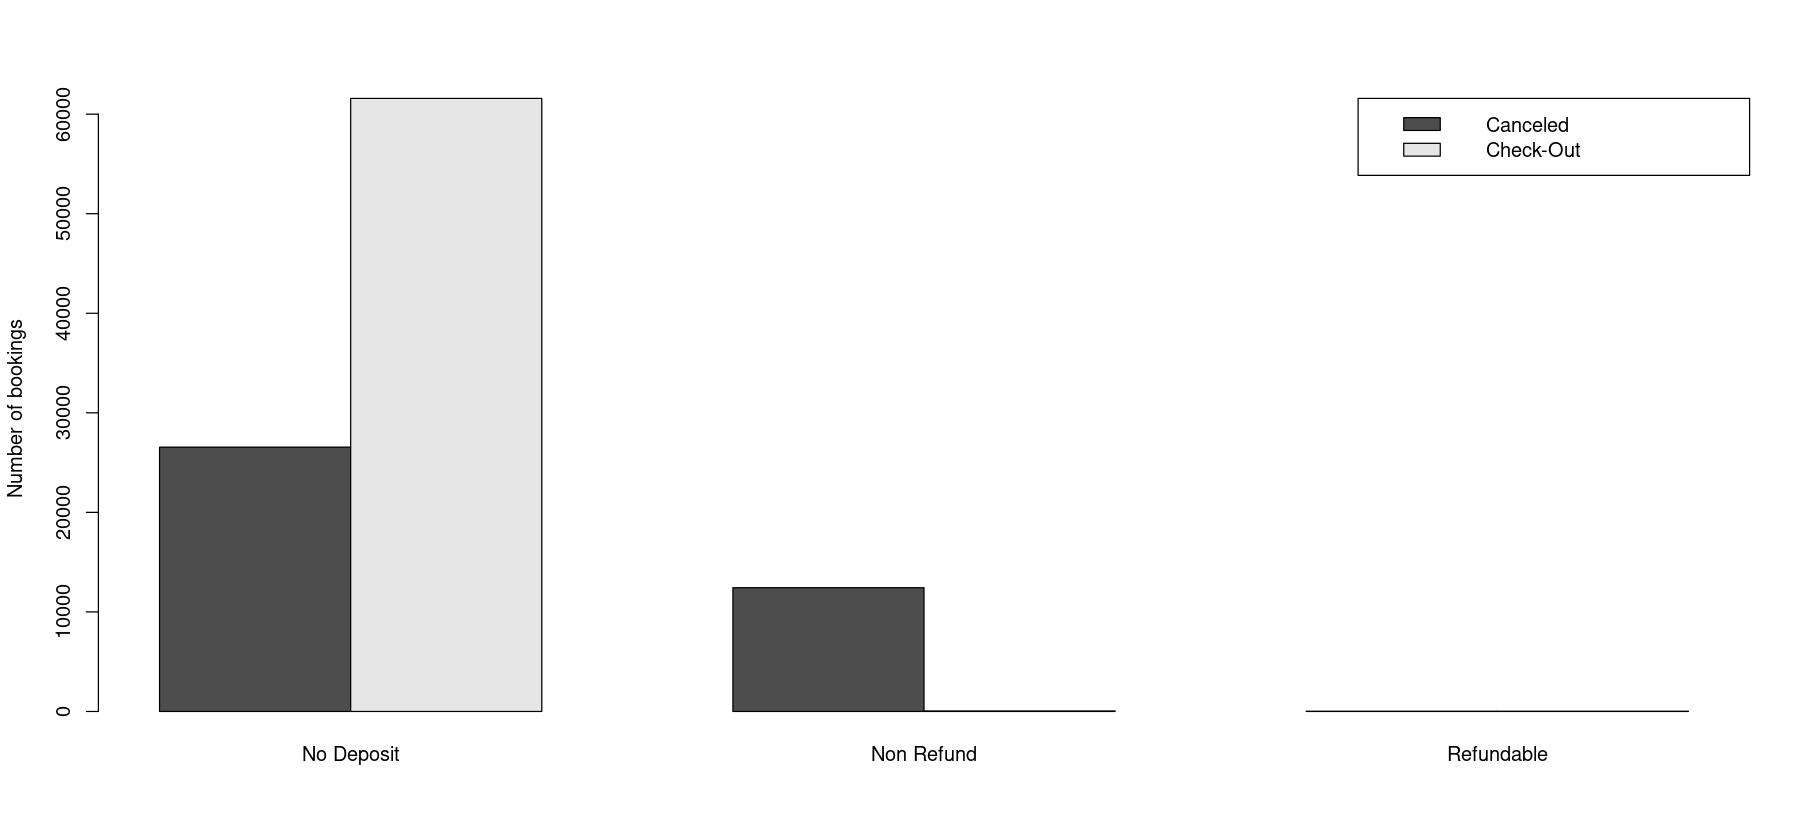

In [17]:
aux <- with(hotel_data, table(reservation_status, deposit_type))
barplot(aux,
        beside = TRUE,
        ylab = 'Number of bookings',
        legend.text = rownames(aux),
        args.legend = list(x = 'topright')
       )

Podemos, também, olhar para histórico dos clientes.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



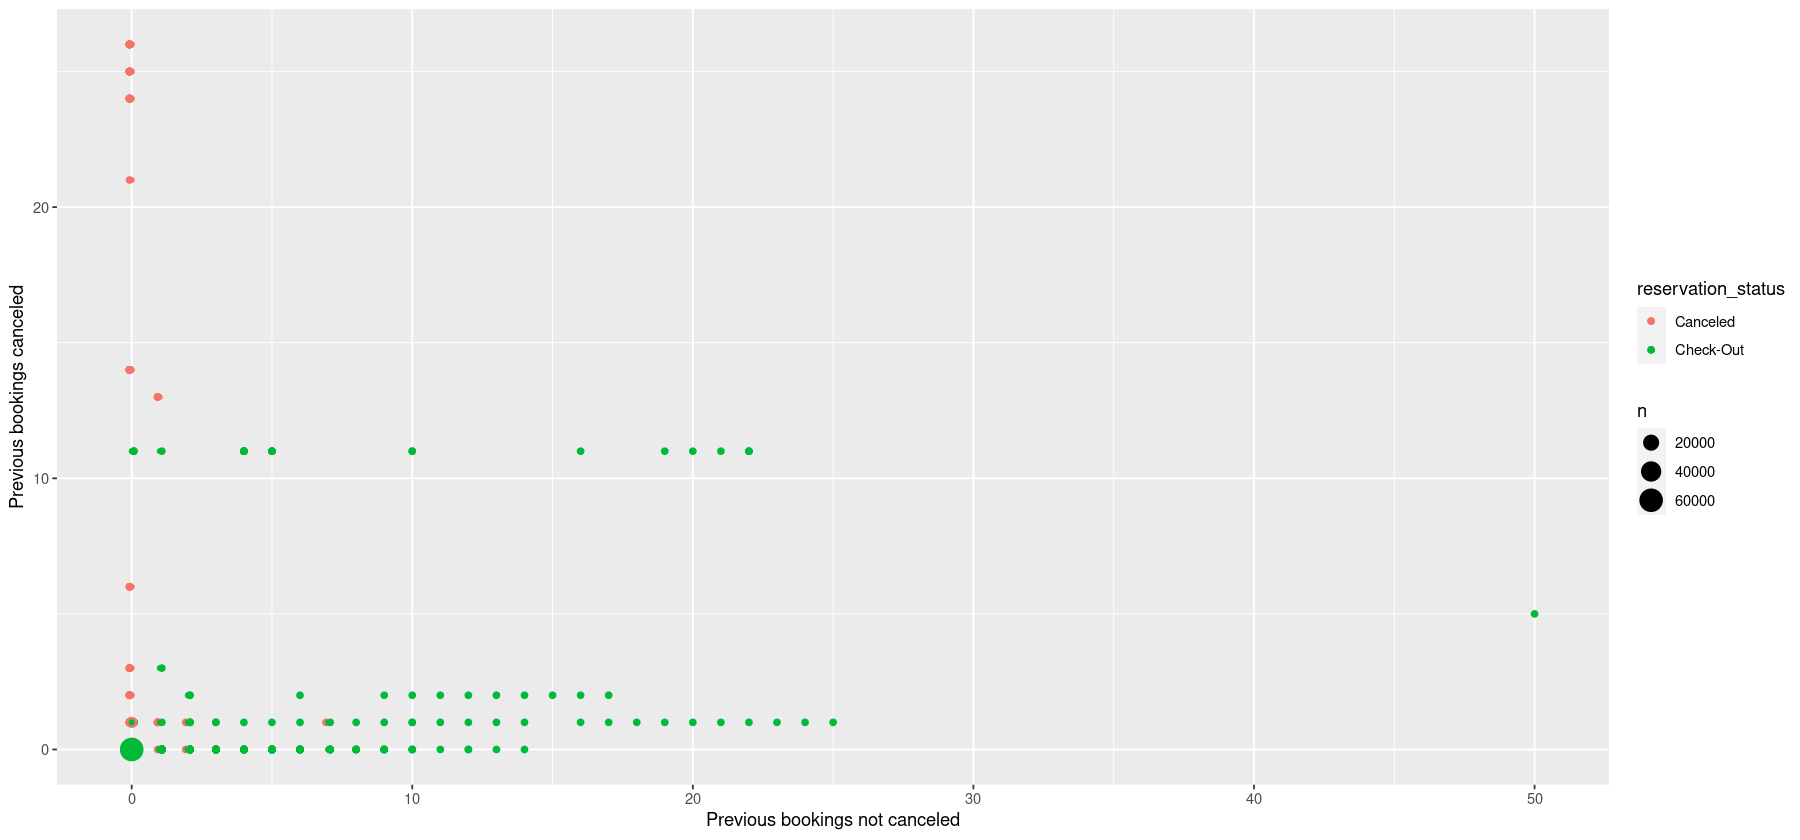

In [18]:
ggplot(hotel_data,
       aes(x = previous_bookings_not_canceled,
           y = previous_cancellations,
           colour = reservation_status)) +
geom_point(position = position_dodge(width = .3)) +
scale_color_discrete('Status') +
xlab('Previous bookings not canceled') +
ylab('Previous bookings canceled') +
scale_color_manual(values = c('#F7726C', '#01BA38')) +
geom_count()

Olhando para o histórico dos clientes, podemos ver que apenas dois clientes reservaram hotel mais que três vezes, ficaram no hotel e, em algum momento, cancelaram uma outra reserva. Assim, pelo histórico do cliente, podemos começar a criar algumas hipóteses acerca da decisão do cliente, como a de que o cliente que se hospedou três ou mais vezes deve, ao reservar um quarto, realmente utilizar o quarto e não cancelar.

Podemos também olhar para as reservas de garagem e pedidos adicionais.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



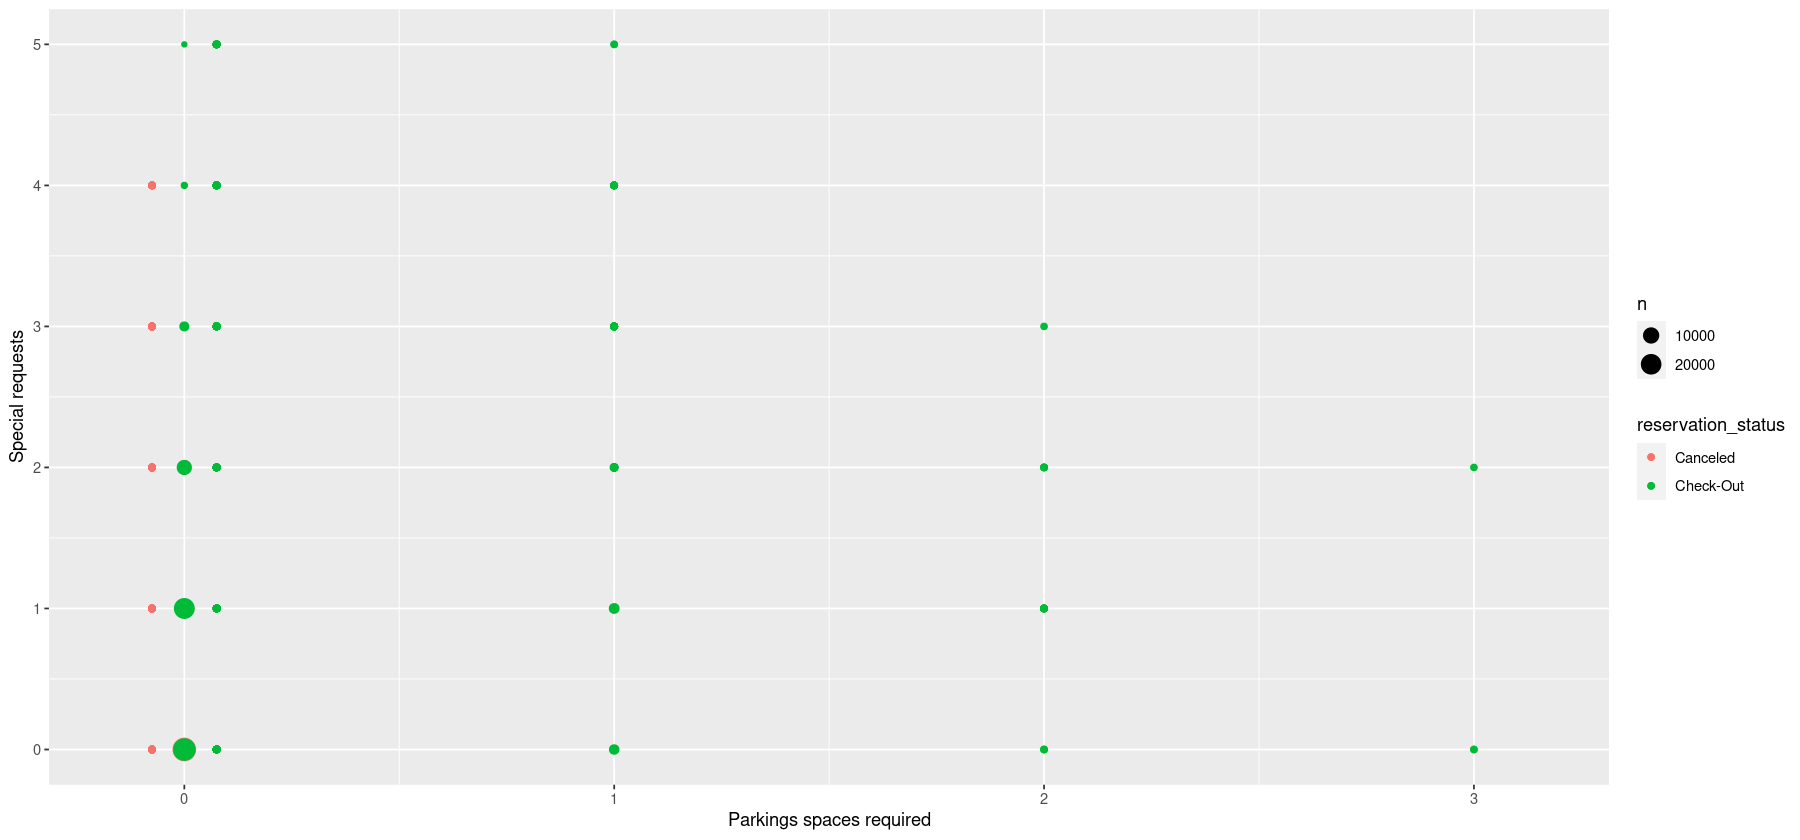

In [19]:
ggplot(hotel_data,
       aes(x = required_car_parking_spaces,
           y = total_of_special_requests,
           colour = reservation_status)) +
geom_point(position = position_dodge(width = .3)) +
scale_color_discrete('Status') +
xlab('Parkings spaces required') +
ylab('Special requests') +
scale_color_manual(values = c('#F7726C', '#01BA38')) +
geom_count()

No gráfico acima, um fato que chama a atenção é que nenhum cliente que solicitou espaço de estacionamento cancelou a reserva. Será que você reservar estacionamento faz com que você esteja mais confiante de que vai viajar?

Por outro lado, quanto a pedidos especiais não podemos afirmar muita coisa, uma vez que há tanto clientes que cancelaram quanto que não cancelaram.

Por fim, vamos para um último gráfico, cruzando o tempo de antecedência na reserva com o preço do quarto.

In [20]:
scatterPlot <- ggplot(hotel_data, 
                      aes(lead_time,
                          adr,
                          color = reservation_status)) + 
               geom_point() + 
               theme(legend.position = c(1, 1),
                     legend.justification = c(1, 1)) +
               xlab('Lead time') +
               ylab('Average Daily Rate') +
               scale_color_manual(values = c('#F7726C', '#01BA38'))

xdensity <- ggplot(hotel_data,
                   aes(lead_time,
                       fill = reservation_status)) + 
            geom_density(alpha = 0.5) + 
            theme(legend.position = 'none') +
            xlab('Lead time') +
            ylab('Density') +
            scale_fill_manual(values = c('#F7726C', '#01BA38'))

ydensity <- ggplot(hotel_data,
                   aes(adr,
                       fill = reservation_status)) + 
            geom_density(alpha = 0.5) + 
            theme(legend.position = 'none') +
            xlab('Average Daily Rate') +
            ylab('Density') +
            scale_fill_manual(values = c('#F7726C', '#01BA38'))

blankPlot <- ggplot() +
             geom_blank(aes(1,1)) +
             theme(plot.background = element_blank(), 
                   panel.grid.major = element_blank(),
                   panel.grid.minor = element_blank(), 
                   panel.border = element_blank(),
                   panel.background = element_blank(),
                   axis.title.x = element_blank(),
                   axis.title.y = element_blank(),
                   axis.text.x = element_blank(), 
                   axis.text.y = element_blank(),
                   axis.ticks = element_blank(),
                   axis.line = element_blank())

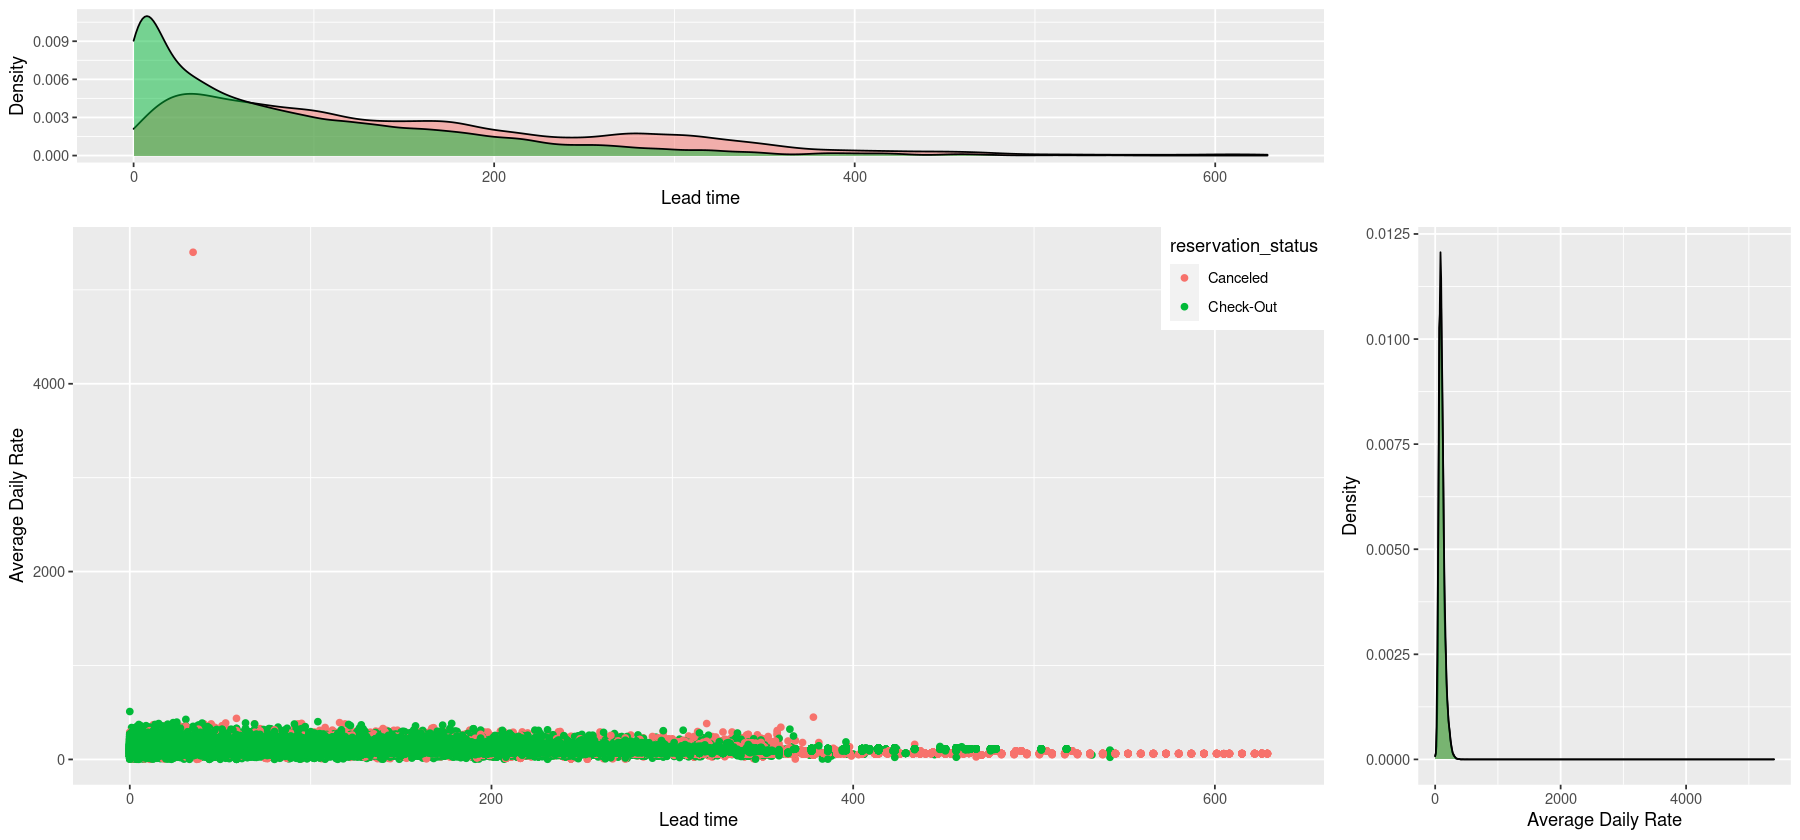

In [21]:
grid.arrange(xdensity,
             blankPlot,
             scatterPlot,
             ydensity,
             ncol = 2,
             nrow = 2,
             widths = c(4, 1.4),
             heights = c(1.4, 4))

Como temos um outlier, o gráfico fica com uma péssima leitura, assim, fazendo o filtro, temos

In [22]:
scatterPlot <- ggplot(hotel_data[hotel_data$adr < 4000, ],
                      aes(lead_time,
                          adr,
                          color = reservation_status)) + 
               geom_point() + 
               theme(legend.position = c(1, 1),
                     legend.justification = c(1, 1)) +
               xlab('Lead time') +
               ylab('Average Daily Rate') +
               scale_color_manual(values = c('#F7726C', '#01BA38'))

xdensity <- ggplot(hotel_data[hotel_data$adr < 4000, ],
                   aes(lead_time,
                       fill = reservation_status)) + 
            geom_density(alpha = 0.5) + 
            theme(legend.position = 'none') +
            xlab('Lead time') +
            ylab('Density') +
            scale_fill_manual(values = c('#F7726C', '#01BA38'))

ydensity <- ggplot(hotel_data[hotel_data$adr < 4000, ],
                   aes(adr,
                       fill = reservation_status)) + 
            geom_density(alpha = 0.5) + 
            theme(legend.position = 'none') +
            xlab('Average Daily Rate') +
            ylab('Density') +
            scale_fill_manual(values = c('#F7726C', '#01BA38'))

blankPlot <- ggplot() +
             geom_blank(aes(1,1)) +
             theme(plot.background = element_blank(), 
                   panel.grid.major = element_blank(),
                   panel.grid.minor = element_blank(), 
                   panel.border = element_blank(),
                   panel.background = element_blank(),
                   axis.title.x = element_blank(),
                   axis.title.y = element_blank(),
                   axis.text.x = element_blank(), 
                   axis.text.y = element_blank(),
                   axis.ticks = element_blank(),
                   axis.line = element_blank())

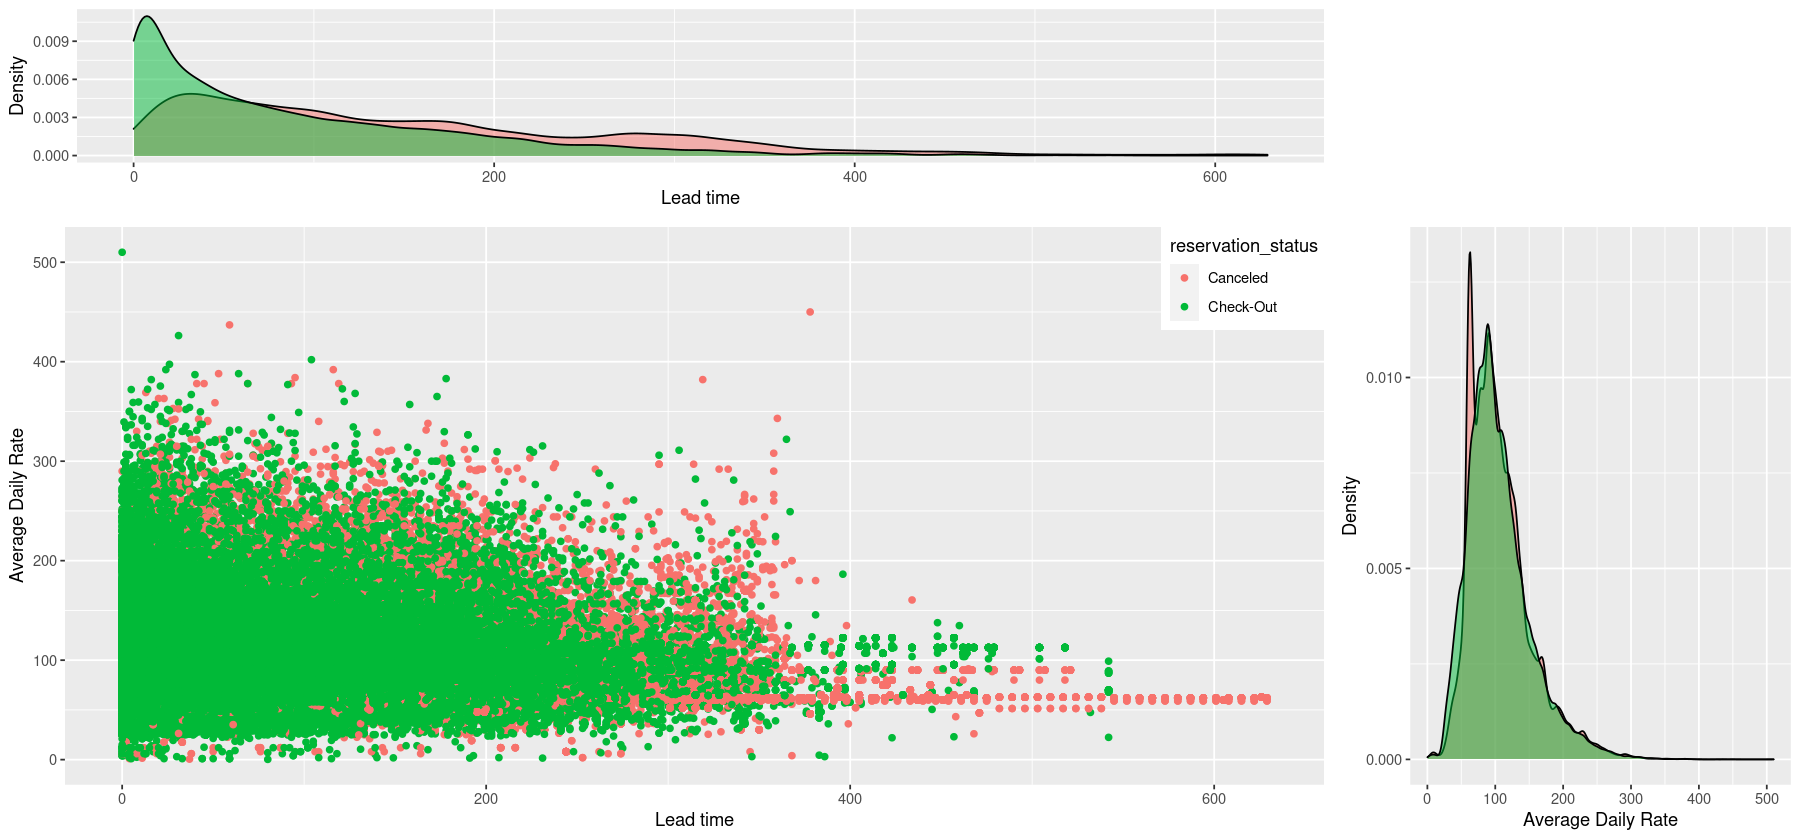

In [23]:
grid.arrange(xdensity,
             blankPlot,
             scatterPlot,
             ydensity,
             ncol = 2,
             nrow = 2,
             widths = c(4, 1.4),
             heights = c(1.4, 4))

Podemos notar que os pontos estão relativamente bem espalhados, mas tem uma classe que se destaca pelo alinhamento. Além disso, pode-se perceber que nas faixas de cerca de \\$50 a \\$100 há uma grande quantidade de clientes que reservaram quarto e cancelaram sua reserva, mudando apenas o intervalo de antecedência da reserva.

Por fim, por meio das distribuições de valor médio e de tempo de antecedência na reserva, vemos que o pico de gastos é mais à direita para os clientes que de fato se hospedaram, o que faz sentido, uma vez que esses clientes tiveram que pagar integralmente, enquanto quem cancelou pode ter pago apenas a taxa de cancelamento, por exemplo. Já para o tempo de antecedência, vemos que a cauda dos clientes que cancelaram é mais pesada, isso é, eles tendem a realizar as reservas mais antecipadamente.

Para realizar as regressões vou remover as colunas de data do status da reserva e de status da reserva (essa última tendo correlação $1$ com a variável que queremos predizer!) com o intuito de simplicidade na hora de realizar as chamadas das funções.

In [24]:
hotel_data <- hotel_data[, - which(names(hotel_data) == 'reservation_status_date')]
hotel_data <- hotel_data[, - which(names(hotel_data) == 'reservation_status')]
logistic_regression <- glm(is_canceled ~ ., data = hotel_data)
summary(logistic_regression)


Call:
glm(formula = is_canceled ~ ., data = hotel_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.24084  -0.28499  -0.08055   0.29839   1.49151  

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -1.610e+01  5.323e+00  -3.025 0.002488 ** 
hotelResort Hotel              -1.512e-02  4.948e-03  -3.057 0.002238 ** 
lead_time                       6.204e-04  1.385e-05  44.807  < 2e-16 ***
arrival_date_year               8.035e-03  2.643e-03   3.040 0.002363 ** 
arrival_date_month              1.490e-01  1.312e-02  11.364  < 2e-16 ***
arrival_date_week_number       -3.354e-02  3.015e-03 -11.126  < 2e-16 ***
arrival_date_day_of_month       4.666e-03  4.532e-04  10.295  < 2e-16 ***
stays_in_weekend_nights         1.384e-02  1.384e-03  10.001  < 2e-16 ***
stays_in_week_nights            9.874e-03  7.610e-04  12.976  < 2e-16 ***
adults                          3.973e-02  2.941e-03  13.509  < 